# EDA on Seattle real estates

## Introduction

In this EDA I will use the King County Housing Data: This dataset contains information about home sales in King County (USA). The description of the column names can be found in the [column_names.md](../00_prep/column_names.md) and [feature_description.md](../00_prep/feature_description.md) file.

<img src="../03_images/overview_Seattle.jpg" title="Seattle overview" width="360">

My client Amy Williams is a house seller. She "works" as an Italian mafiosi and sells several central houses (top10%) over time. Now she is looking for average outskirt houses over time to hide from the FBI.

## Hypothesis

It is good practice to write down some assumptions and expectations of the data before I start analyzing. I try to confirm or infirm these assumptions during the EDA.

|Question|Hypothesis|Indicator|
|---|---|---|
|Are outskirt houses cheaper then central ones?|1. The closer the house is to the city center, the higher the price.|geolocation, price|
||2.||
|Lot of houses will be bigger in the outskirts?|1. The closer the house is to the city center, the lower the sqft_lot.|geolocation, sqft_lot|
|In downtown Seattle the number of floors will be higher than in the outskirts?|1. The closer the house is to the city center, the higher the number of floors.|geolocation, floors|
|Are older houses cheaper compared to new ones?|1. The older the house is, the cheaper the price.|yr_built, price|
|Are new renovated houses more expensive?|1. The newer renovated the house is, the higher the price.|price, yr_renovated|
|Are houses with grade >= 11 the Top10% with price?|1. If the 10% top priced houses are all in grade >= 11, then true.|price, grade|
||||
|**Interesting for my client:**|||
|What is the price-range for Top10%-houses (Grade >= 11 ?) in the center (over time)?|1. 10% not def. (price, grade, condition) / price / month / in center|date, grade, price, geolocation|
|What is the average (mean) price for average houses (Grade = 7) in the outskirts over time?|avg price per year / compared to month / not in center or downtown|date, mean(price), geolocation|
|Average houses (Grade = 7) in the north of Seattle (close to highway/freeway access) to "quickly" escape the police to Canada (2.5h drive - 140 miles).||grade, zipcodes|
|When is a good selling / buying time in the year?||price, date, geolocation|
||||


## Explore

This is the time to explore the data, check for missing data, extreme values, outliers. Looking at the usual suspects when you look at values: the appearance of groups, skewness, appearance of unexpected values, where are the data values centered and how widely are values separated. Do all this meet your expectations from your domain knowledge?

### Import packages for working with the data, setting everything up:


In [59]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
from ydata_profiling import ProfileReport

%matplotlib inline
sns.set(style="white", font_scale=1)

#from matplotlib.ticker import PercentFormatter
#plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
#plt.rcParams["figure.facecolor"]= "w"
#pd.plotting.register_matplotlib_converters()
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Import the dataset and looking at a few rows of the data


In [60]:
df = pd.read_csv('./data/eda.csv')
df = df.drop(columns='id.1', axis=1) # dropping because same info as house.id
df.head(10)

date      price    house_id  id  bedrooms  bathrooms  sqft_living  \
0  2014-10-13   221900.0  7129300520   1       3.0       1.00       1180.0   
1  2014-12-09   538000.0  6414100192   2       3.0       2.25       2570.0   
2  2015-02-25   180000.0  5631500400   3       2.0       1.00        770.0   
3  2014-12-09   604000.0  2487200875   4       4.0       3.00       1960.0   
4  2015-02-18   510000.0  1954400510   5       3.0       2.00       1680.0   
5  2014-05-12  1230000.0  7237550310   6       4.0       4.50       5420.0   
6  2014-06-27   257500.0  1321400060   7       3.0       2.25       1715.0   
7  2015-01-15   291850.0  2008000270   8       3.0       1.50       1060.0   
8  2015-04-15   229500.0  2414600126   9       3.0       1.00       1780.0   
9  2015-03-12   323000.0  3793500160  10       3.0       2.50       1890.0   

   sqft_lot  floors  waterfront  ...  grade  sqft_above  sqft_basement  \
0    5650.0     1.0         NaN  ...      7      1180.0            0.0   
1    7242.0     2.0         0.0  ...      7      2170.0          400.0   
2   10000.0     1.0         0.0  ...      6       770.0            0.0   
3    5000.0     1.0         0.0  ...      7      1050.0          910.0   
4    8080.0     1.0         0.0  ...      8      1680.0            0.0   
5  101930.0     1.0         0.0  ...     11      3890.0         1530.0   
6    6819.0     2.0         0.0  ...      7      1715.0            NaN   
7    9711.0     1.0         0.0  ...      7      1060.0            0.0   
8    7470.0     1.0         0.0  ...      7      1050.0          730.0   
9    6560.0     2.0         0.0  ...      7      1890.0            0.0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955           0.0    98178  47.5112 -122.257         1340.0   
1      1951       19910.0    98125  47.7210 -122.319         1690.0   
2      1933           NaN    98028  47.7379 -122.233         2720.0   
3      1965           0.0    98136  47.5208 -122.393         1360.0   
4      1987           0.0    98074  47.6168 -122.045         1800.0   
5      2001           0.0    98053  47.6561 -122.005         4760.0   
6      1995           0.0    98003  47.3097 -122.327         2238.0   
7      1963           0.0    98198  47.4095 -122.315         1650.0   
8      1960           0.0    98146  47.5123 -122.337         1780.0   
9      2003           0.0    98038  47.3684 -122.031         2390.0   

   sqft_lot15  
0      5650.0  
1      7639.0  
2      8062.0  
3      5000.0  
4      7503.0  
5    101930.0  
6      6819.0  
7      9711.0  
8      8113.0  
9      7570.0  

[10 rows x 22 columns]

### Check for missing data and datatypes

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   house_id       21597 non-null  int64  
 3   id             21597 non-null  int64  
 4   bedrooms       21597 non-null  float64
 5   bathrooms      21597 non-null  float64
 6   sqft_living    21597 non-null  float64
 7   sqft_lot       21597 non-null  float64
 8   floors         21597 non-null  float64
 9   waterfront     19206 non-null  float64
 10  view           21534 non-null  float64
 11  condition      21597 non-null  int64  
 12  grade          21597 non-null  int64  
 13  sqft_above     21597 non-null  float64
 14  sqft_basement  21145 non-null  float64
 15  yr_built       21597 non-null  int64  
 16  yr_renovated   17749 non-null  float64
 17  zipcode        21597 non-null  int64  
 18  lat   

- there are 18 features (removing id and house_id) and the target variable price
- waterfront, view, sqft_basement and yr_renovated have missing values

In [62]:
print(f"numbers of rows : {df.shape[0]}")
print(f"missing values in waterfront : {round(df.waterfront.isna().sum()/df.shape[0]*100,2)} %, total: {df.waterfront.isna().sum()}")
print(f"missing values in view : {round(df.view.isna().sum()/df.shape[0]*100,2)} %, total: {df.view.isna().sum()}")
print(f"missing values in sqft_basement : {round(df.sqft_basement.isna().sum()/df.shape[0]*100,2)} %, total: {df.sqft_basement.isna().sum()}")
print(f"missing values in yr_renovated : {round(df.yr_renovated.isna().sum()/df.shape[0]*100,2)} %, total: {df.yr_renovated.isna().sum()}")
print(f"missing values in data frame : {round(df.isna().sum().sum()/(df.shape[0]*df.shape[1])*100,2)} %")


numbers of rows : 21597
missing values in waterfront : 11.07 %, total: 2391
missing values in view : 0.29 %, total: 63
missing values in sqft_basement : 2.09 %, total: 452
missing values in yr_renovated : 17.82 %, total: 3848
missing values in data frame : 1.42 %


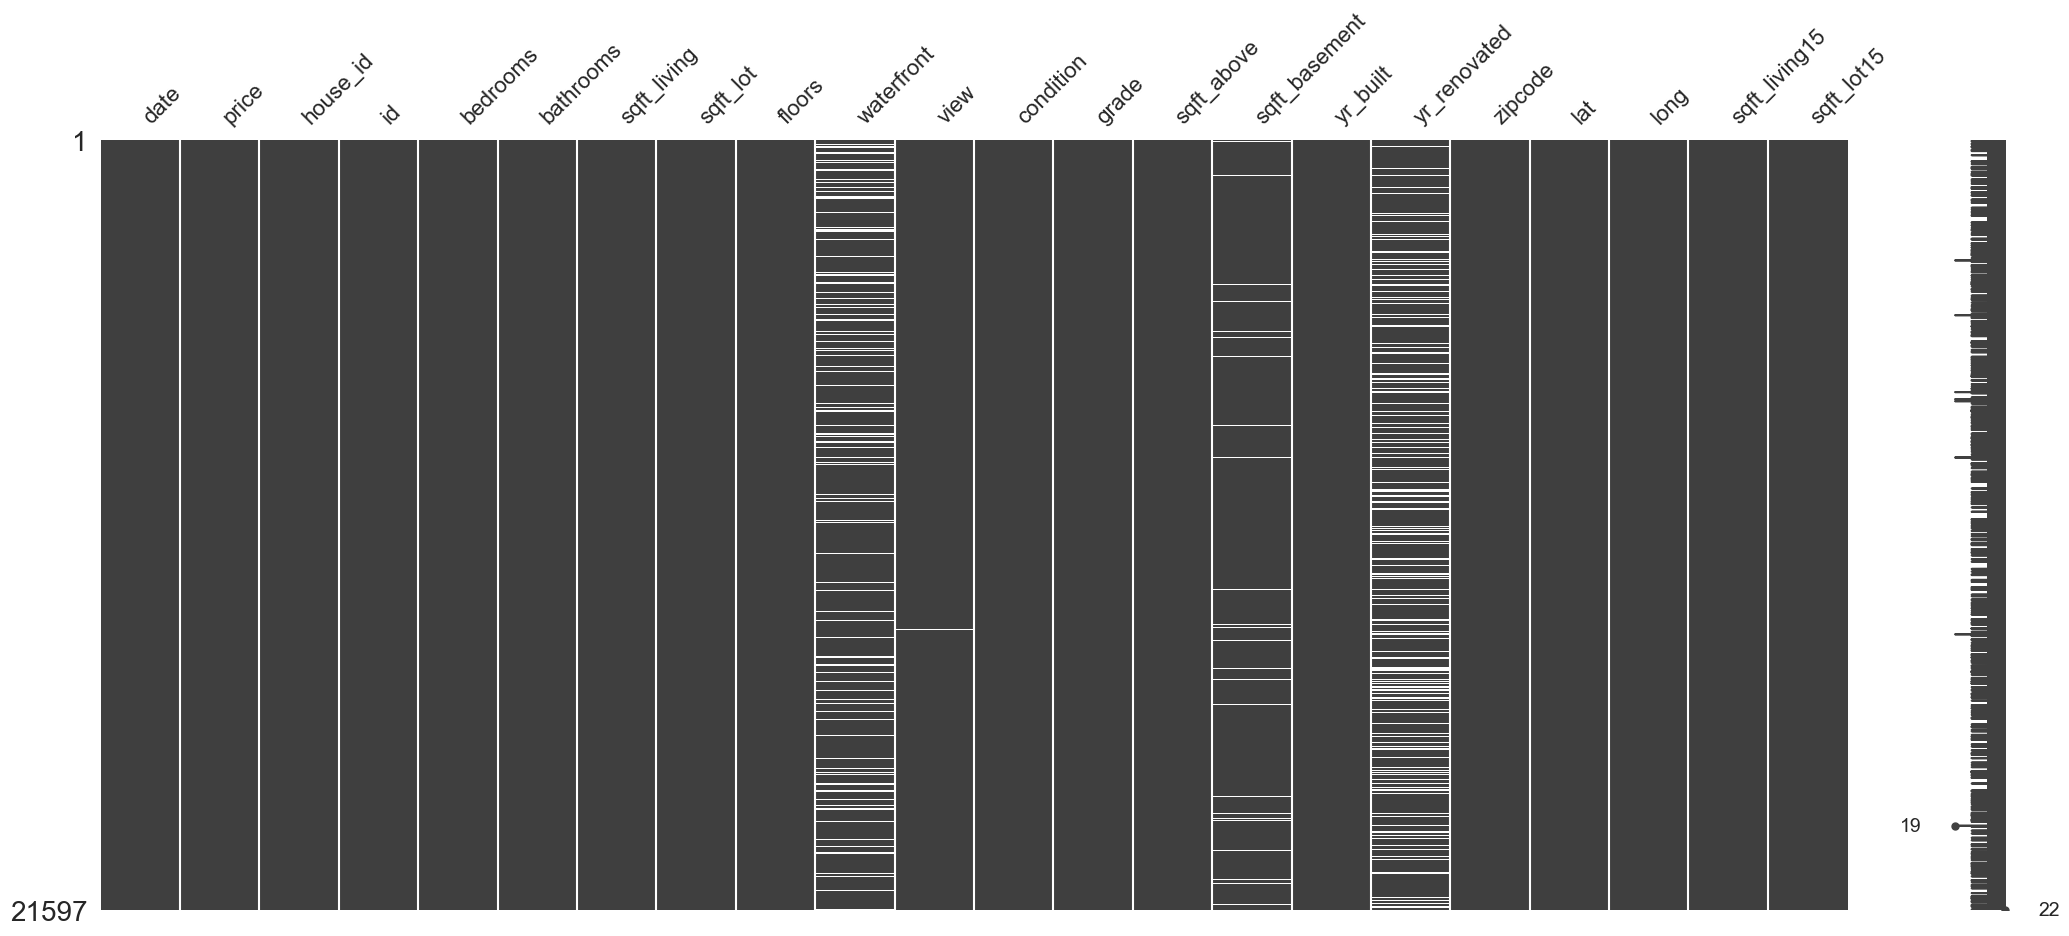

In [63]:
msno.matrix(df);

We have 21597 rows and about one fifth of them have missing values in at least one column. This would actual be too much to drop. Fortunately my client is not interested in the year of renovation, view, sqft_basement or if the house has a view to a waterfront. I could drop the columns without loosing to much information. 

### Check for duplicates

In [64]:
df.duplicated().value_counts()

False    21597
Name: count, dtype: int64

Horray, no dublicates 💪🏼

### Examine the usual suspects: number of unique values

In [65]:
df.nunique()

date               372
price             3622
house_id         21420
id               21597
bedrooms            12
bathrooms           29
sqft_living       1034
sqft_lot          9776
floors               6
waterfront           2
view                 5
condition            5
grade               11
sqft_above         942
sqft_basement      303
yr_built           116
yr_renovated        70
zipcode             70
lat               5033
long               752
sqft_living15      777
sqft_lot15        8682
dtype: int64

### Changing datatype of date column to datetime

In [66]:
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')

### Create new columns with year, month and day of date column


In [67]:
df['date_year'] = df['date'].dt.year
df['date_month'] = df['date'].dt.month
df['date_day'] = df['date'].dt.day
df.head()

date     price    house_id  id  bedrooms  bathrooms  sqft_living  \
0 2014-10-13  221900.0  7129300520   1       3.0       1.00       1180.0   
1 2014-12-09  538000.0  6414100192   2       3.0       2.25       2570.0   
2 2015-02-25  180000.0  5631500400   3       2.0       1.00        770.0   
3 2014-12-09  604000.0  2487200875   4       4.0       3.00       1960.0   
4 2015-02-18  510000.0  1954400510   5       3.0       2.00       1680.0   

   sqft_lot  floors  waterfront  ...  yr_built  yr_renovated  zipcode  \
0    5650.0     1.0         NaN  ...      1955           0.0    98178   
1    7242.0     2.0         0.0  ...      1951       19910.0    98125   
2   10000.0     1.0         0.0  ...      1933           NaN    98028   
3    5000.0     1.0         0.0  ...      1965           0.0    98136   
4    8080.0     1.0         0.0  ...      1987           0.0    98074   

       lat     long  sqft_living15  sqft_lot15  date_year  date_month  \
0  47.5112 -122.257         1340.0      5650.0       2014          10   
1  47.7210 -122.319         1690.0      7639.0       2014          12   
2  47.7379 -122.233         2720.0      8062.0       2015           2   
3  47.5208 -122.393         1360.0      5000.0       2014          12   
4  47.6168 -122.045         1800.0      7503.0       2015           2   

   date_day  
0        13  
1         9  
2        25  
3         9  
4        18  

[5 rows x 25 columns]

In [68]:
print(f"Min date: {df['date'].min()}")
print(f"Max date: {df.date.max()}")

Min date: 2014-05-02 00:00:00
Max date: 2015-05-27 00:00:00


### Feature generation: north, center, downtown

<Axes: >

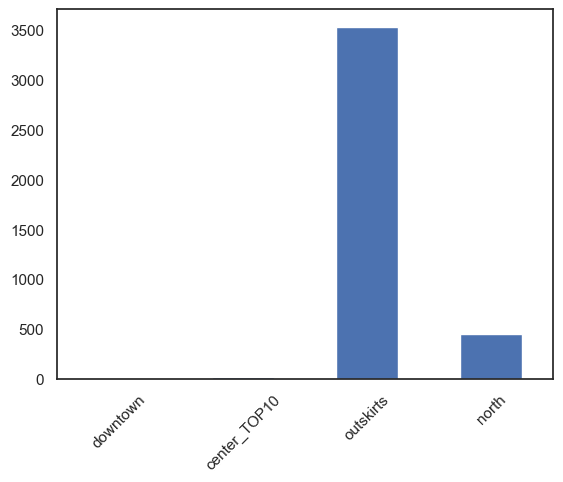

In [69]:
zip_north = [98011, 98028, 98072, 98125, 98133, 98155, 98177]
zip_center = [98102, 98109, 98112, 98119, 98122, 98144, 98134]
zip_downtown = [98101, 98104, 98121, 98154, 98164, 98174]

data_lst = [{'downtown': 0, 'center_TOP10': 17, 'outskirts': 3531, 'north': 449}]
df_sizes = pd.DataFrame(data_lst).T
df_sizes.head()
df_sizes.plot(kind='bar', legend=False, rot=45)

### Wondering why there are only 11 categories for "grade", since definition gives 13 grades

In [70]:
df['grade'].sort_values().unique()

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

Grade 1 and 2 not used.

###  TODO: number of zipcodes not corresponding my zipcode shapefile

In [71]:
# TODO: think about it later
df['zipcode'].sort_values().unique()

array([98001, 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98010,
       98011, 98014, 98019, 98022, 98023, 98024, 98027, 98028, 98029,
       98030, 98031, 98032, 98033, 98034, 98038, 98039, 98040, 98042,
       98045, 98052, 98053, 98055, 98056, 98058, 98059, 98065, 98070,
       98072, 98074, 98075, 98077, 98092, 98102, 98103, 98105, 98106,
       98107, 98108, 98109, 98112, 98115, 98116, 98117, 98118, 98119,
       98122, 98125, 98126, 98133, 98136, 98144, 98146, 98148, 98155,
       98166, 98168, 98177, 98178, 98188, 98198, 98199])

### FIXME: 33 bedrooms must be a hotel; very suspect, not more than 11 and the large gap

In [72]:
# FIXME: 33 bedrooms must be a hotel; very suspect, not more than 11 and the large gap
df['bedrooms'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 33.])

In [73]:
df['bathrooms'].sort_values().unique()

array([0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  ,
       3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25, 5.5 , 5.75,
       6.  , 6.25, 6.5 , 6.75, 7.5 , 7.75, 8.  ])

## Univariate analysis:

### changing datatype of yr_renovated column to datetime

In [74]:
df.yr_renovated = df.yr_renovated.astype('Int32')
df.yr_renovated = df.yr_renovated / 10
df.yr_renovated = df.yr_renovated.astype('Int32')
df['yr_renovated'].replace(0, np.nan, inplace=True)
#df.yr_renovated = df.yr_renovated.astype('str')
df['yr_renovated'] = pd.to_datetime(df['yr_renovated'], format='%Y')
#df['yr_renovated'] = df['yr_renovated'].dt.year
#df['yr_renovated'] = df['yr_renovated'][0].isocalender()[0]

df.head()

date     price    house_id  id  bedrooms  bathrooms  sqft_living  \
0 2014-10-13  221900.0  7129300520   1       3.0       1.00       1180.0   
1 2014-12-09  538000.0  6414100192   2       3.0       2.25       2570.0   
2 2015-02-25  180000.0  5631500400   3       2.0       1.00        770.0   
3 2014-12-09  604000.0  2487200875   4       4.0       3.00       1960.0   
4 2015-02-18  510000.0  1954400510   5       3.0       2.00       1680.0   

   sqft_lot  floors  waterfront  ...  yr_built  yr_renovated  zipcode  \
0    5650.0     1.0         NaN  ...      1955           NaT    98178   
1    7242.0     2.0         0.0  ...      1951    1991-01-01    98125   
2   10000.0     1.0         0.0  ...      1933           NaT    98028   
3    5000.0     1.0         0.0  ...      1965           NaT    98136   
4    8080.0     1.0         0.0  ...      1987           NaT    98074   

       lat     long  sqft_living15 sqft_lot15  date_year  date_month  date_day  
0  47.5112 -122.257         1340.0     5650.0       2014          10        13  
1  47.7210 -122.319         1690.0     7639.0       2014          12         9  
2  47.7379 -122.233         2720.0     8062.0       2015           2        25  
3  47.5208 -122.393         1360.0     5000.0       2014          12         9  
4  47.6168 -122.045         1800.0     7503.0       2015           2        18  

[5 rows x 25 columns]

In [75]:
type(df["yr_renovated"][0])
print(df.yr_renovated[0])
print(df.yr_renovated.sort_values(ascending=False).value_counts())
print(type(df.yr_renovated[0]))

NaT
yr_renovated
2014-01-01    73
2013-01-01    31
2003-01-01    31
2007-01-01    30
2000-01-01    29
              ..
1953-01-01     1
1954-01-01     1
1959-01-01     1
1976-01-01     1
1934-01-01     1
Name: count, Length: 69, dtype: int64
<class 'pandas._libs.tslibs.nattype.NaTType'>


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21597 non-null  datetime64[ns]
 1   price          21597 non-null  float64       
 2   house_id       21597 non-null  int64         
 3   id             21597 non-null  int64         
 4   bedrooms       21597 non-null  float64       
 5   bathrooms      21597 non-null  float64       
 6   sqft_living    21597 non-null  float64       
 7   sqft_lot       21597 non-null  float64       
 8   floors         21597 non-null  float64       
 9   waterfront     19206 non-null  float64       
 10  view           21534 non-null  float64       
 11  condition      21597 non-null  int64         
 12  grade          21597 non-null  int64         
 13  sqft_above     21597 non-null  float64       
 14  sqft_basement  21145 non-null  float64       
 15  yr_built       2159

### Uncomment both lines if you want a quick profile of your data

In [77]:
#profile = ProfileReport(df, minimal=False)
#profile.to_file("./data/output.html")

### Data Overview

This is not a very big data and we do not have too many features. Thus, we have chance to plot most of them and reach some useful analytical results. Drawing charts and examining the data before applying a model is a very good practice because we may detect some possible outliers or decide to do normalization. This is not a must but get know the data is always good. Then, I started with the histograms of dataframe.

In [78]:
df1=df[['price', 'bedrooms', 'bathrooms', 'sqft_living',
    'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
    'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
    'lat', 'long', 'sqft_living15', 'sqft_lot15']]
h = df1.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

In [79]:
df_top_10 = df.sort_values(by='price', ascending=False).head(10)
df_top_10.price.mean()
df_top_10.grade.unique()

array([13, 11, 12])

### Looking at histogramm of price

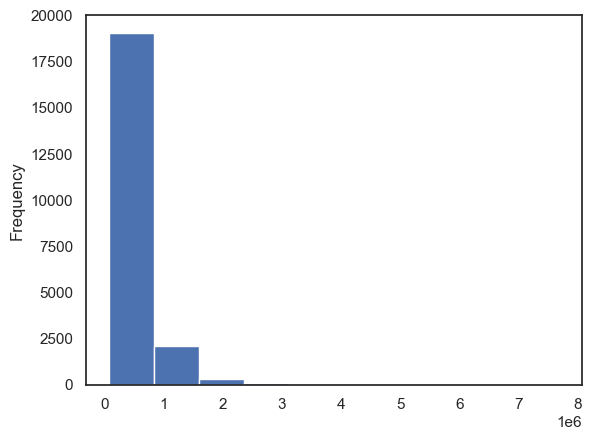

In [80]:
df.price.plot(kind='hist');

Lot of houses (ca. 19000) below $1.000.000, some (ca 2500) between $1.000.000 and $2.000.000, few more extrem (up to $8.000.000).

### Histogram grouped by grade

In [81]:
df['price'].groupby(df["grade"]).plot(kind="hist", alpha=0.8);
plt.legend();

### Histogram grouped by grade under $2.000.000

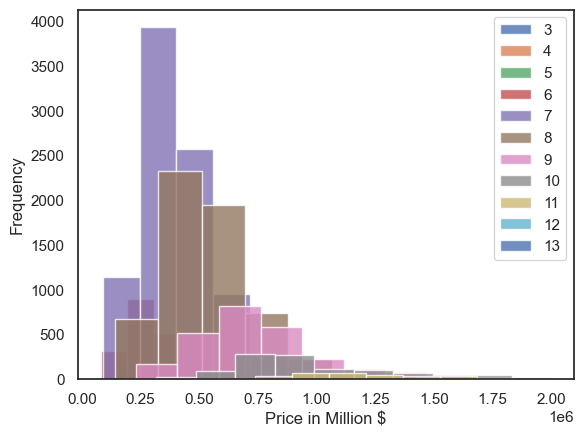

In [82]:
df_price_under2000000 = df[df['price'] <= 2000000]
df_price_under2000000['price'].groupby(df_price_under2000000["grade"]).plot(kind="hist", alpha=0.8, xlabel='Price in Million $');
plt.legend();

### Histogram grouped by grade over $2.000.000

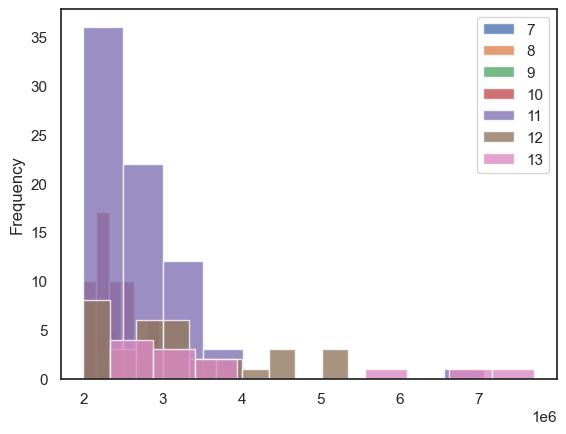

In [83]:
df_price_over2000000 = df[df['price'] >= 2000000]
df_price_over2000000['price'].groupby(df_price_over2000000["grade"]).plot(kind="hist", alpha=0.8, );
plt.legend();

### Histogram house with grade 3

3220    262000.0
Name: price, dtype: float64


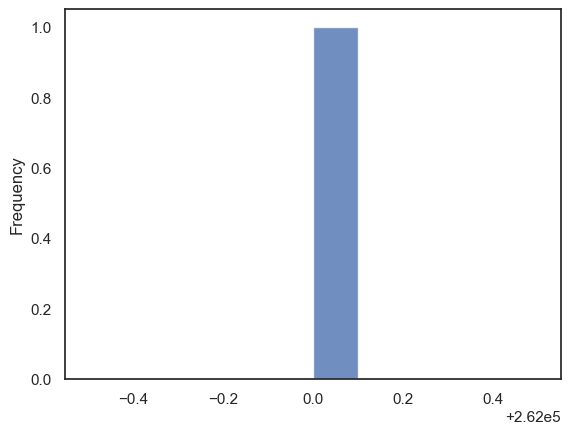

In [84]:
df_grade03 = df[df['grade'] == 3]
print(df_grade03['price'])
df_grade03['price'].plot(kind="hist", alpha=0.8);

### Histogram houses with grade 4

In [85]:
df_grade04 = df[df['grade'] == 4]
print(f"Number of Houses: {df_grade04['id'].count()}")
print(f"Median price ($): {df_grade04['price'].median()}")
print(f"Mean price ($): {round(df_grade04['price'].mean(), 2)}")
df_grade04['price'].plot(kind="hist", alpha=0.8);

Number of Houses: 27
Median price ($): 200000.0
Mean price ($): 212001.85


### Histogram houses with grade 5

Number of Houses: 242
Median price ($): 228700.0


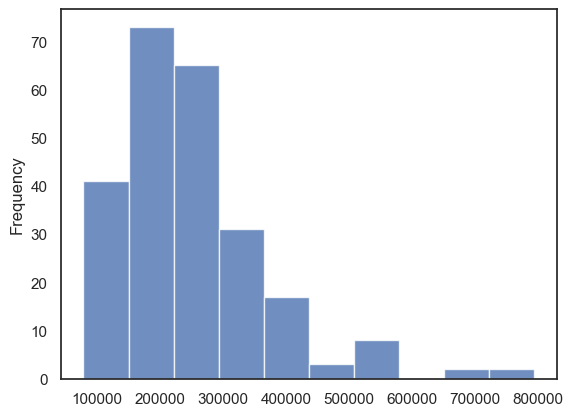

In [86]:
df_grade05 = df[df['grade'] == 5]
print(f"Number of Houses: {df_grade05['id'].count()}")
print(f"Median price ($): {df_grade05['price'].median()}")
df_grade05['price'].plot(kind="hist", alpha=0.8);

### Histogram houses with grade 6

Number of Houses: 2038
Median price ($): 275276.5


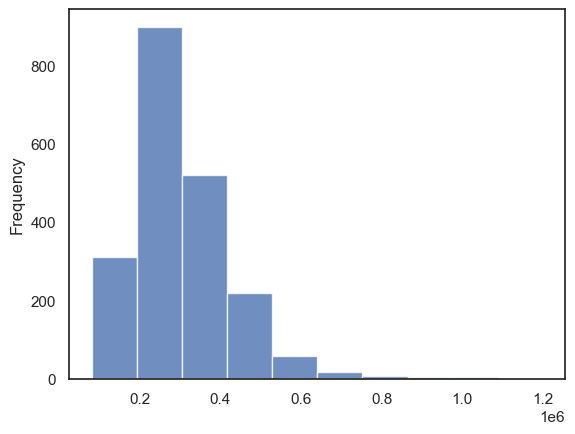

In [87]:
df_grade06 = df[df['grade'] == 6]
print(f"Number of Houses: {df_grade06['id'].count()}")
print(f"Median price ($): {df_grade06['price'].median()}")
df_grade06['price'].plot(kind="hist", alpha=0.8);

### IMPORTANT: Histogram houses with grade 7

Number of Houses: 8974
Median price ($): 375000.0
Mean price ($): 402594.57


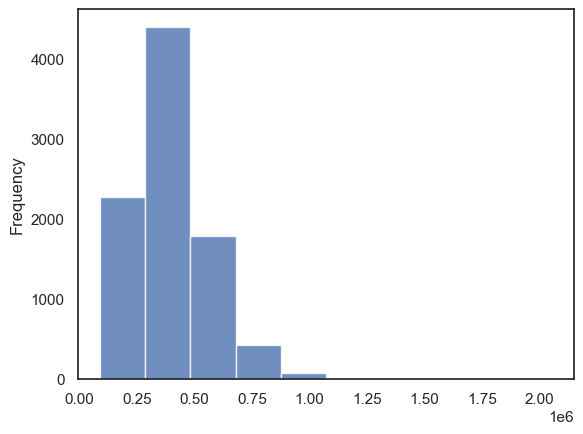

In [88]:
df_grade07 = df[df['grade'] == 7]
print(f"Number of Houses: {df_grade07['id'].count()}")
print(f"Median price ($): {df_grade07['price'].median()}")
print(f"Mean price ($): {round(df_grade07['price'].mean(), 2)}")
df_grade07['price'].plot(kind="hist", alpha=0.8);

### Histogram houses with grade 8

Number of Houses: 6065
Median price ($): 510000.0
Mean price ($): 542986.8


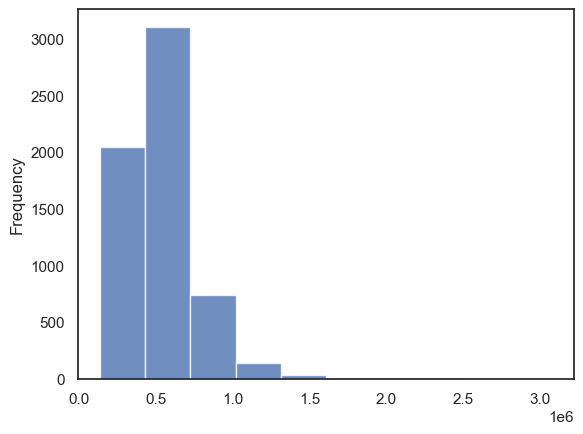

In [89]:
df_grade08 = df[df['grade'] == 8]
print(f"Number of Houses: {df_grade08['id'].count()}")
print(f"Median price ($): {df_grade08['price'].median()}")
print(f"Mean price ($): {round(df_grade08['price'].mean(), 2)}")
df_grade08['price'].plot(kind="hist", alpha=0.8);

### Histogram houses with grade 9

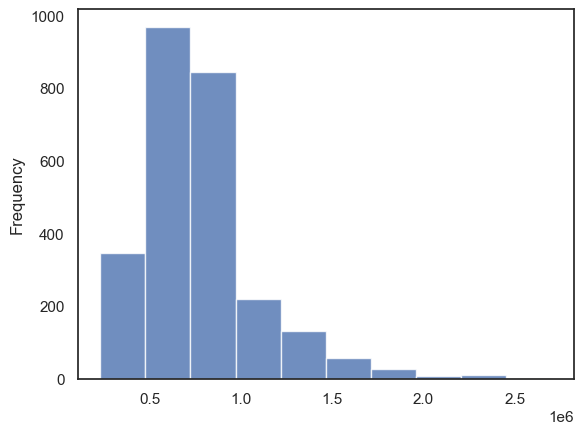

In [90]:
df_grade09 = df[df['grade'] == 9]
df_grade09['price'].plot(kind="hist", alpha=0.8);

### Histogram houses with grade 10

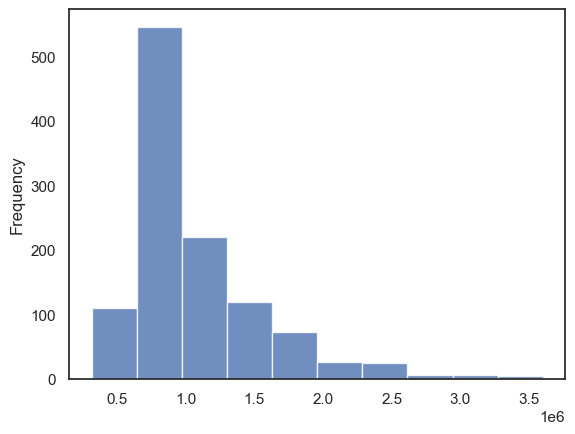

In [91]:
df_grade10 = df[df['grade'] == 10]
df_grade10['price'].plot(kind="hist", alpha=0.8);

### Histogram houses with grade 11

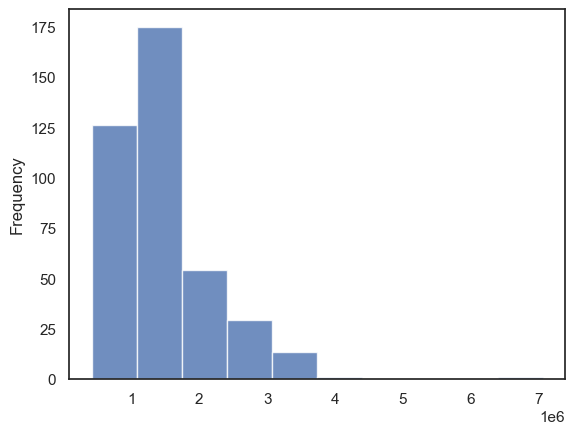

In [92]:
df_grade11 = df[df['grade'] == 11]
df_grade11['price'].plot(kind="hist", alpha=0.8);

### Price in million $ by grade

In [93]:
f, axe = plt.subplots(1, 1,figsize=(12.18,5))
sns.boxplot(x=df['grade'],y=df['price'], ax=axe)
sns.despine(left=True, bottom=True)
axe.yaxis.tick_left()
axe.set(xlabel='Grade', ylabel='Price in million $');

### Houses colored by grade

In [94]:
#wa_zipcodes = pd.read_json('./data/wa_washington_zip_codes_geo.min.geojson')

fig = px.scatter_mapbox(
    df, 
    lat="lat", 
    lon="long", 
    hover_name="house_id", 
    hover_data=["price", "grade", "zipcode"],
    color="grade", 
    height=600, 
    width=600,
    title="Houses colored by grade")
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()

### Houses colored by price and location

In [95]:
fig = px.scatter_mapbox(
    df_price_under2000000, 
    lat="lat", 
    lon="long", 
    hover_name="house_id", 
    hover_data=["price", "grade", "zipcode"],
    color="price", 
    height=600,
    width=600,
    title="Houses colored by price")
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})

### Houses in the North of Seattle <br> grade 7 colored by condition

In [96]:
#df['zipcode_area'] = 


df_north = df[(df['zipcode'].isin(zip_north)) & (df['grade'] == 7) & (df['condition'] >= 4)]
print(df_north['id'].count())
#df_downtown = df[(df['zipcode'].isin(zip_downtown) == True) & (df['grade'] >= 11) & (df['condition'] >= 4)]

fig = px.scatter_mapbox(
    df_north,
    lat="lat",
    lon="long",
    hover_name="house_id",
    hover_data=["price", "grade", "zipcode"],
    color="condition",
    width=600,
    height=400,
    title="Houses in the North of Seattle <br> grade 7 colored by condition")
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

449


Number of houses: 449
Median price ($): 405000.0


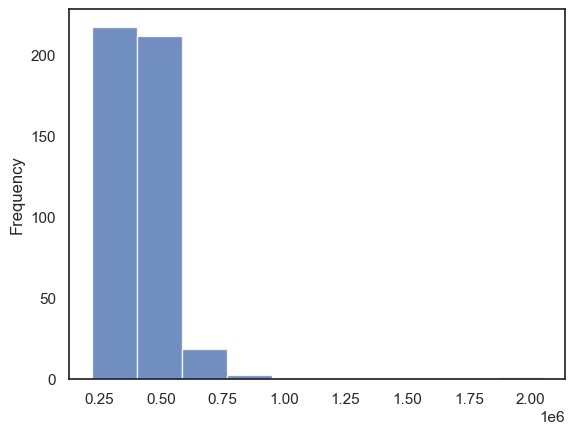

In [97]:
print(f"Number of houses: {df_north['id'].count()}")
print(f"Median price ($): {df_north['price'].median()}")
df_north['price'].plot(kind="hist", alpha=0.8);

<Axes: xlabel='date'>

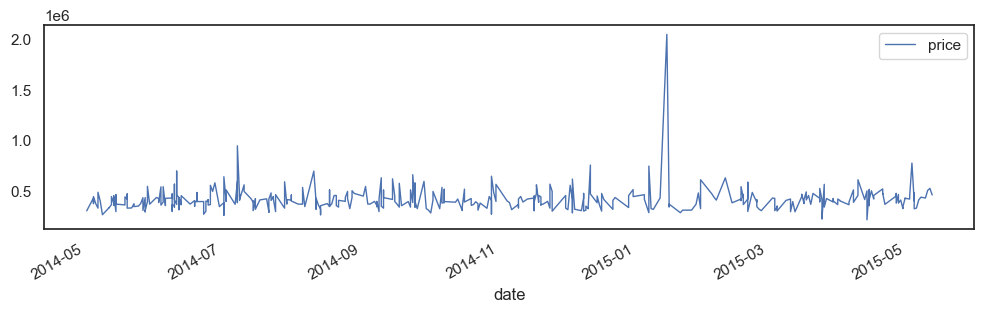

In [98]:
# time series
df_north.plot.line(x="date", y=("price"), figsize=(12, 3), lw=1)
#df1.plot.line(x=df1.index, y='B', figsize=(12, 3), lw=1)

In [99]:
df_downtown = df[(df['zipcode'].isin(zip_downtown))] # & (df['grade'] <= 11)] & (df['condition'] >= 4)

print(f"Number of houses: {df_downtown['id'].count()}")
print(f"Median price ($): {df_downtown['price'].median()}")
# df_downtown['price'].plot(kind="hist", alpha=0.8);

# fig = px.scatter_mapbox(
#     df_downtown,
#     lat="lat",
#     lon="long",
#     hover_name="house_id",
#     hover_data=["price", "grade", "zipcode"],
#     color="condition",
#     height=300,
#     title="Houses in downtown of Seattle <br> grade 7 colored by condition")
# fig.update_layout(mapbox_style="open-street-map")
# fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
# fig.show()

Number of houses: 0
Median price ($): nan


## Q1: What is the price-range for Top10%-houses (Grade >= 11 ?) in the center (over time)?

In [100]:
df_center = df[(df['zipcode'].isin(zip_center)) & (df['grade'] >= 11) & (df['condition'] >= 4)]

print(f"Number of houses: {df_center['id'].count()}")
print(f"Median price ($): {df_center['price'].median()}")
print(f"Max price ($): {df_center['price'].max()}")
print(f"Min price ($): {df_center['price'].min()}")
print(f"Min price ($): {df_center['date_month'].min()}")
print(f"Median price top10% by price: {round(df.sort_values('price', ascending=False)['price'].head(2140).mean(),2)}")
df_center['price'].plot(kind="hist", alpha=0.8);

fig = px.scatter_mapbox(
    df_center,
    lat="lat",
    lon="long",
    hover_name="house_id",
    hover_data=["price", "grade", "zipcode"],
    color="condition",
    width=600,
    height=600,
    title="Houses in center of Seattle <br> grade >= 11 colored by condition")
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

Number of houses: 17
Median price ($): 2500000.0
Max price ($): 7700000.0
Min price ($): 1500000.0
Min price ($): 2
Median price top10% by price: 1349322.41


<Axes: xlabel='date', ylabel='Price ($)'>

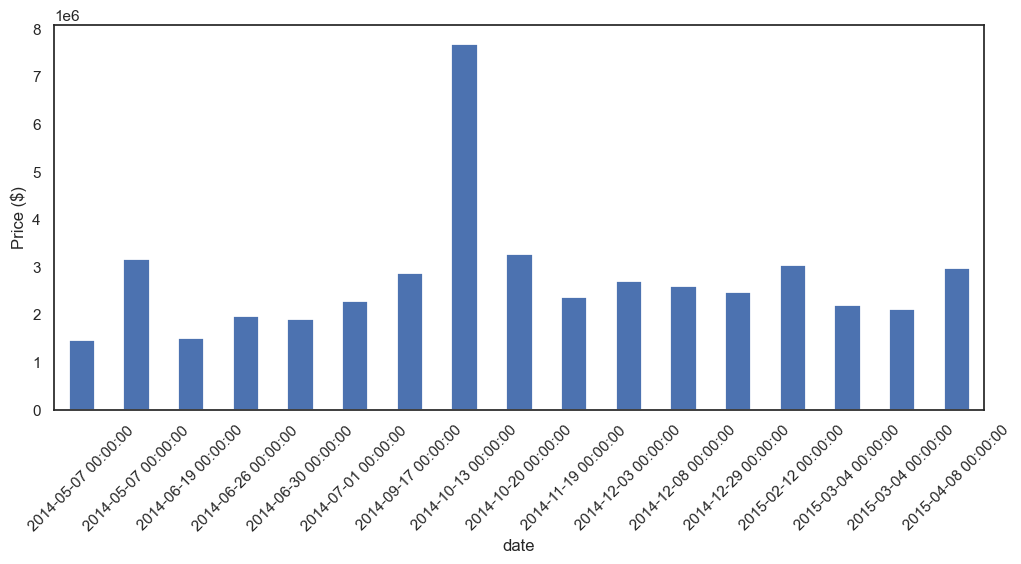

In [101]:
# time series
df_center[['date', 'price']].sort_values(by='date').plot.bar(x="date", y=("price"), figsize=(12, 5), lw=2, legend=False, rot=45, ylabel='Price ($)')
#df1.plot.line(x=df1.index, y='B', figsize=(12, 3), lw=1)


### Q2: What is the average (median) price for average houses (Grade = 7) in the outskirts over time?

Number of houses: 3531
Median price ($): 399950.0
Max price ($): 2050000.0
Min price ($): 115000.0
Min price ($): 1
Median price top10% by price: 1349322.41


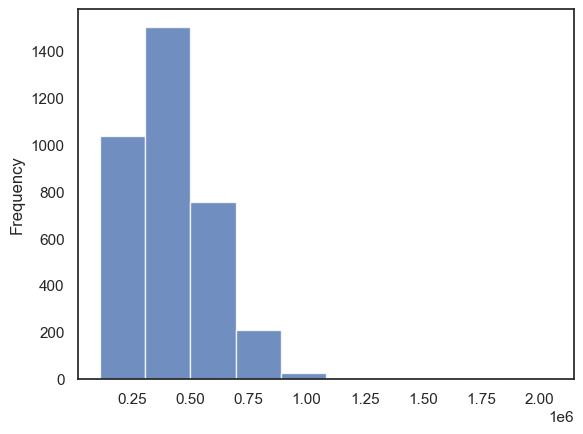

In [102]:
df_outskirts = df[(~df['zipcode'].isin(zip_center)) & (df['grade'] == 7) & (df['condition'] >= 4)]

print(f"Number of houses: {df_outskirts['id'].count()}")
print(f"Median price ($): {df_outskirts['price'].median()}")
print(f"Max price ($): {df_outskirts['price'].max()}")
print(f"Min price ($): {df_outskirts['price'].min()}")
print(f"Min price ($): {df_outskirts['date_month'].min()}")
print(f"Median price top10% by price: {round(df.sort_values('price', ascending=False)['price'].head(2140).mean(),2)}")
df_outskirts['price'].plot(kind="hist", alpha=0.8);

fig = px.scatter_mapbox(
    df_outskirts,
    lat="lat",
    lon="long",
    hover_name="house_id",
    hover_data=["price", "grade", "zipcode"],
    color="condition",
    width=600,
    height=600,
    title="Houses in outskirts of Seattle <br> grade = 7 colored by condition")
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

Median price ($): 419980.1579629855
                    price
date_month               
1           397287.621622
2           420957.423256
3           423010.847222
4           449873.590214
5           424611.096698
6           424936.920110
7           419002.892670
8           417705.432692
9           417568.950355
10          417297.886288
11          427245.000000
12          408515.315589


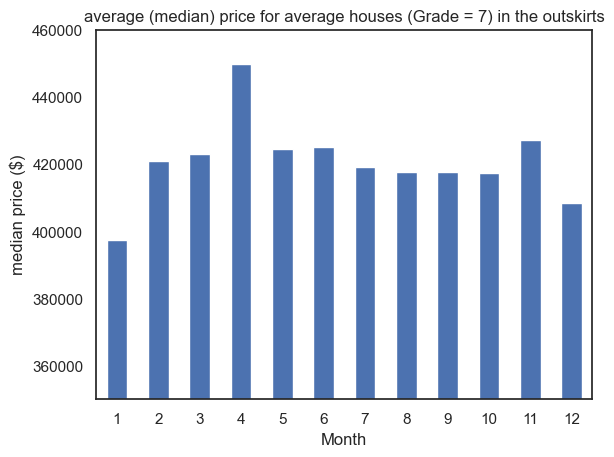

In [103]:
# time series
outskirts_month = df_outskirts[['date_month', 'price']].groupby(['date_month']).mean()
print(f"Median price ($): {outskirts_month['price'].median()}")
print(outskirts_month.head(12))
outskirts_month.plot(kind='bar', rot=0, ylim=[350000,460000], xlabel='Month', ylabel='median price ($)', title='average (median) price for average houses (Grade = 7) in the outskirts', legend=False);

#(df_outskirts['price'].median()).plot.bar(x="date_month", y="price", figsize=(12, 3), lw=1)

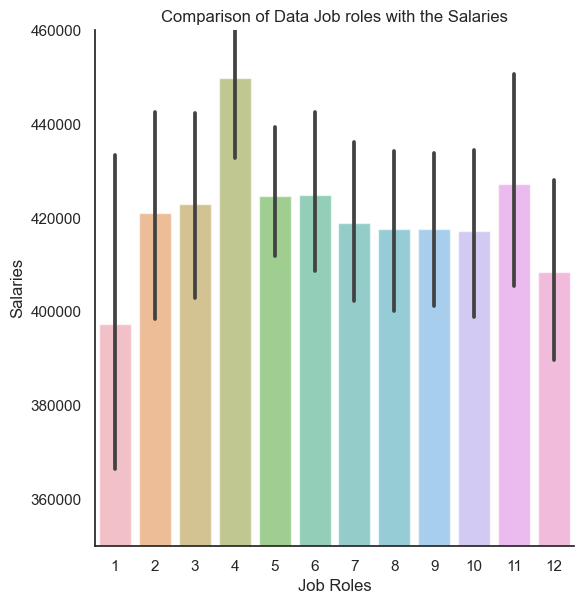

In [104]:
g = sns.catplot(
    data=df_outskirts, kind="bar",
    x="date_month", y="price",
    alpha=.6, height=6
)
plt.ylim((350000,460000))
plt.xlabel("Job Roles")
plt.ylabel("Salaries")
plt.Line2D(df_outskirts['date_month'], outskirts_month[['price']].median())
g.set(title="Comparison of Data Job roles with the Salaries")
plt.show()

In [105]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
                   dtype={"fips": str})

import plotly.express as px

fig = px.choropleth(df, geojson=counties, locations='df_center', color='unemp',
                           color_continuous_scale="Viridis",
                           range_color=(0, 12),
                           scope="usa",
                           labels={'unemp':'unemployment rate'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

ValueError: Value of 'locations' is not the name of a column in 'data_frame'. Expected one of ['fips', 'unemp'] but received: df_center

In [ ]:

import json
df_zip_shapes = pd.read_json('./data/wa_washington_zip_codes_geo.min.geojson')

df_zip_shapes["features"][0]

{'type': 'Feature',
 'properties': {'STATEFP10': '53',
  'ZCTA5CE10': '98822',
  'GEOID10': '5398822',
  'CLASSFP10': 'B5',
  'MTFCC10': 'G6350',
  'FUNCSTAT10': 'S',
  'ALAND10': 1131837710,
  'AWATER10': 5582389,
  'INTPTLAT10': '+47.9019257',
  'INTPTLON10': '-120.5504512',
  'PARTFLG10': 'N'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-120.479846, 47.683729],
    [-120.480083, 47.683762],
    [-120.480478, 47.683852],
    [-120.480574, 47.68386],
    [-120.481009, 47.6839],
    [-120.481272, 47.68396],
    [-120.481441, 47.684062],
    [-120.481525, 47.684253],
    [-120.481534, 47.684613],
    [-120.481602, 47.684858],
    [-120.481793, 47.68506],
    [-120.481963, 47.6852],
    [-120.481972, 47.685208],
    [-120.482047, 47.685299],
    [-120.481999, 47.68546],
    [-120.481924, 47.685657],
    [-120.481982, 47.685829],
    [-120.482023, 47.685861],
    [-120.482137, 47.685949],
    [-120.482403, 47.685993],
    [-120.482507, 47.686011],
    [-120.483198, 47.686035],
 

In [ ]:
import plotly.express as px

fig = px.choropleth(df, geojson=counties, locations='fips', color='unemp',
                           color_continuous_scale="Viridis",
                           range_color=(0, 12),
                           scope="usa",
                           labels={'unemp':'unemployment rate'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
!pip install plotly-geo==1.0.0
!pip install geopandas==0.3.0
!pip install pyshp==1.2.10
!pip install shapely==1.6.3

In [ ]:
import plotly.figure_factory as ff

#fips = ['06021', '06023', '06027',
#        '06029', '06033', '06059',
#        '06047', '06049', '06051',
#        '06055', '06061']
values = range(len(zip_north))

fig = ff.create_choropleth(fips=zip_north, values=values)
fig.layout.template = None
fig.show()

ImportError: geopandas, pyshp and shapely must be installed for this figure factory.

Run the following commands to install the correct versions of the following modules:

```
$ pip install geopandas==0.3.0
$ pip install pyshp==1.2.10
$ pip install shapely==1.6.3
```
If you are using Windows, follow this post to properly install geopandas and dependencies:http://geoffboeing.com/2014/09/using-geopandas-windows/

If you are using Anaconda, do not use PIP to install the packages above. Instead use conda to install them:

```
$ conda install plotly
$ conda install geopandas
```